# Animals10 Classification
### [Link to dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10)
### Data Loading, EDA, Transformations, Data Structure Conclusions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip -q install opendatasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle
import opendatasets as od
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
plt.style.use('ggplot')

In [ ]:
od.download('https://www.kaggle.com/datasets/alessiocorrado99/animals10')

In [ ]:
data_path = '/content/animals10/raw-img'
data_categories = os.listdir(data_path)
print(data_categories)

['squirrel', 'cow', 'ragno', 'horse', 'butterfly', 'cat', 'dog', 'elephant', 'sheep', 'chicken']


In [ ]:
translate_map = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel"}


In [ ]:
for old_name in os.listdir(data_path):
  if old_name in translate_map:
    new_name = translate_map[old_name]
    os.rename(os.path.join(data_path, old_name), os.path.join(data_path, new_name))

In [ ]:
for c in os.listdir(data_path):
  print(f'{c}: {len(os.listdir(os.path.join(data_path, c)))}')

squirrel: 1862
cow: 1866
ragno: 4821
horse: 2623
butterfly: 2112
cat: 1668
dog: 4863
elephant: 1446
sheep: 1820
chicken: 3098


In [ ]:
eng_data_categories = os.listdir(data_path)

**Data Structure Conclusions**

Looking at the number of images within each class in original data, we observe a significant difference, i.e. for *elephant* we have 1446 images (the lowest value) VS for *dog* there are 4863 (the largest value) of them. This may indicate a possible disbalance amongst classes as there will be more training examples for some classes than for other ones. Therefore, we suggest to consider such metrics of model's performance evaluation as *Precision* and *Recall* as they are influenced less by imbalanced data than *Accuracy*

In [ ]:
# here put your base dir where to save data subsets
base_dir = ''
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
for dir in [train_dir, val_dir, test_dir]:
  os.makedirs(dir, exist_ok=True)
  for c in eng_data_categories:
    os.makedirs(os.path.join(dir, c), exist_ok=True)

In [ ]:
for c in eng_data_categories:
  category_path = os.path.join(data_path, c)
  images = os.listdir(category_path)

  train_images, val_images = train_test_split(images, test_size=0.3, random_state=42)
  val_images, test_images = train_test_split(val_images, test_size=0.5, random_state=42)

  for img in train_images:
    shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, c, img))

  for img in val_images:
    shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, c, img))

  for img in test_images:
    shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, c, img))
  print(f'{c}: {len(train_images)}, {len(val_images)}, {len(test_images)}')

squirrel: 1303, 279, 280
cow: 1306, 280, 280
ragno: 3374, 723, 724
horse: 1836, 393, 394
butterfly: 1478, 317, 317
cat: 1167, 250, 251
dog: 3404, 729, 730
elephant: 1012, 217, 217
sheep: 1274, 273, 273
chicken: 2168, 465, 465


In [ ]:
def count_images_in(directory):
  return {category: len(os.listdir(os.path.join(directory, category))) for category in eng_data_categories}

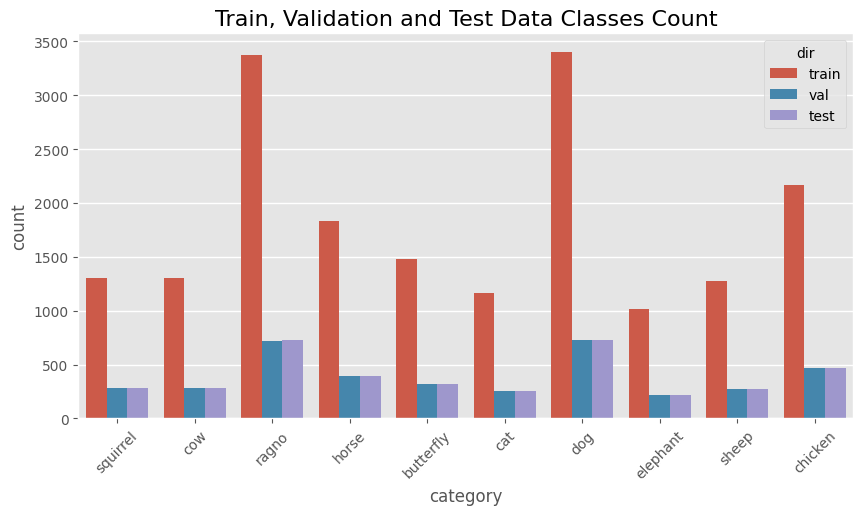

In [ ]:
train_count = count_images_in(train_dir)
val_count = count_images_in(val_dir)
test_count = count_images_in(test_dir)

df = pd.DataFrame({
    'category': list(train_count.keys()),
    'train': list(train_count.values()),
    'val': list(val_count.values()),
    'test': list(test_count.values())
})
df_melted = df.melt(id_vars='category', var_name='dir', value_name='count')

plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x='category', y='count', hue='dir')
plt.title('Train, Validation and Test Data Classes Count', fontsize=16)
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

**Train, Validation and Test Division**

As we utilized a simple *train_test* split for our data, giving 70% for training ang 15% for each validation and test subsets, we see that the data is imbalanced overall. The most represented categories are *ragno*, *dog* and *chicken*, and the least one is *elephant* as it was already mentioned.

We may consider to undersample the data to achieve similar class distribution if our model's performance allows this. It might also be beneficial as it simplifies the training process by cutting the number of training samples, thus, decreasing training time.

In [ ]:
def get_imgs_by_category_from(directory):
  category_images = {}
  for category in os.listdir(directory):
    category_path = os.path.join(directory, category)
    if os.path.isdir(category_path):
      images = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
      if images:
        category_images[category] = os.path.join(category_path, images[0])
  return category_images

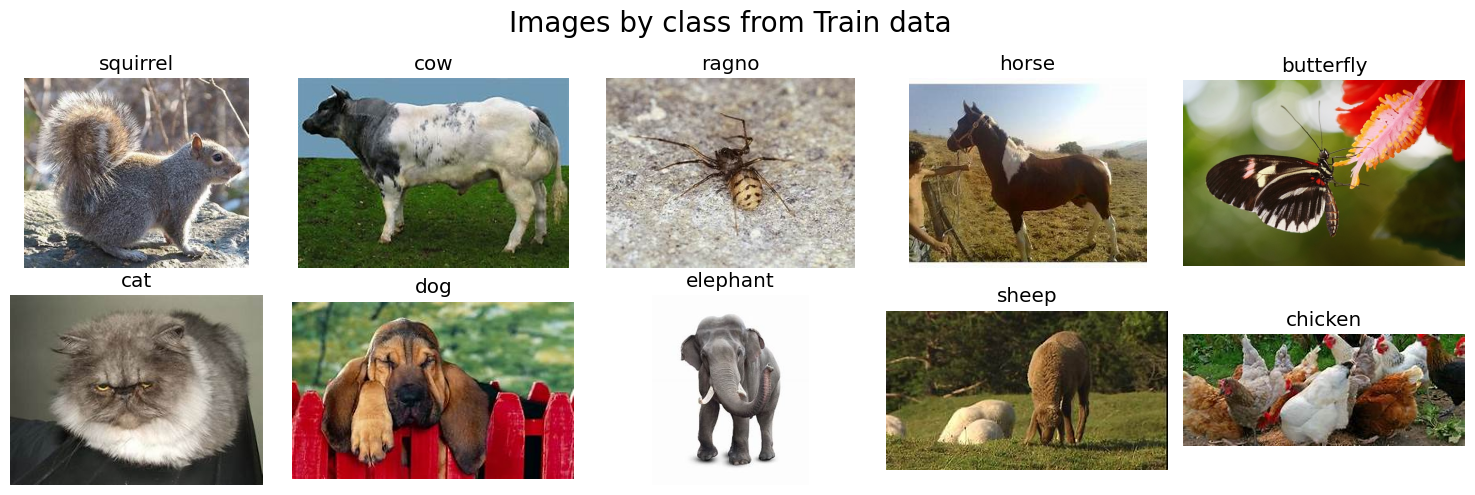

In [ ]:
sample_images = get_imgs_by_category_from(train_dir)
num_classes = len(sample_images)

fig, axes = plt.subplots(2, num_classes // 2, figsize=(15, 5))
axes = axes.flatten()
for ax, (category_name, img_path) in zip(axes, sample_images.items()):
  img = Image.open(img_path)
  ax.imshow(img)
  ax.set_title(category_name)
  ax.axis('off')
plt.suptitle('Images by class from Train data', fontsize=20)
plt.tight_layout()
plt.show()

**Samples Images Conclusion**

Having generated sample images for each category, we observe the difference in their sizes. To help our model generalize better (i.e. do not let it connect size of the image to what is depicted), it will be beneficial to standardize images sizes.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Custom Animals Dataset definition to allow for using different transforms for train, validation and test data subsets

In [ ]:
class AnimalsDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []
    self.categories = []


    for category_idx, category in enumerate(sorted(os.listdir(root_dir))):
      category_path = os.path.join(root_dir, category)
      if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
          img_path = os.path.join(category_path, img_name)
          self.image_paths.append(img_path)
          self.labels.append(category_idx)
        self.categories.append(category)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)
    return image, label

In [ ]:
train_dataset = AnimalsDataset(root_dir=f'{base_dir}/train', transform=train_transforms)
val_dataset = AnimalsDataset(root_dir=f'{base_dir}/val', transform=val_transforms)
test_dataset = AnimalsDataset(root_dir=f'{base_dir}/test', transform=test_transforms)

In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Check how loaders work a with custom dataset


In [ ]:
image, label = next(iter(train_loader))

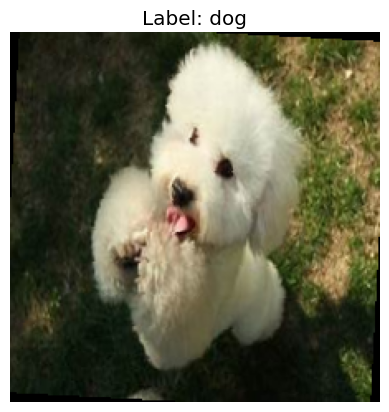

In [ ]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

image = image[0].float()
image = image.permute(1, 2, 0)

image = image * std + mean

image = image.numpy()
category_name = train_loader.dataset.categories[label[0].item()]

plt.imshow(image)
plt.axis('off')
plt.title(f'Label: {category_name}')
plt.show()

Here we are saving data loaders to pickle file to use them in a script where model initialization and training are going to be performed.

In [ ]:
with open(os.path.join(base_dir, 'data_loaders.pkl'), 'wb') as f:
  pickle.dump((train_loader, val_loader, test_loader), f)

**Next Steps Planning**

* **Metrics**: Precision, Recall, F1 score, confusion matrix (as we have multiclass classification problem with imbalanced data)

* **Neural Network Architecture**: 2-4 convolutional layers, 3x3 kernel filter

* **Activation function**: Softmax (as we have multiclass classification)

* **Fully Connected Layers**: 1-2 FC layers may be enough for a base model

* **Optimizer**: Adam or AdamW; we will start with a fixed learning rate and then probably utilize the learning scheduler

* **Loss Function**: Cross Entropy loss

* **Dropout**: could be added, with prob=0.3, for example